In [1]:
import torch 
import torchvision.transforms as transforms
from torch.autograd import Variable
import numpy as np
import math
from torchvision import datasets
import matplotlib.pyplot as plt
from time import time
from torch import nn, optim
import argparse
import csv
import time

/home/farbabi/git/tt-metal/build/python_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


tt metal libs

In [2]:
cd /home/farbabi/git/tt-metal/

/home/farbabi/git/tt-metal


In [3]:
import math, os
from pathlib import Path
import sys

In [4]:
%env TT_METAL_ENV=dev
%env TT_METAL_HOME=/home/farbabi/git/tt-metal

env: TT_METAL_ENV=dev
env: TT_METAL_HOME=/home/farbabi/git/tt-metal


In [5]:
sys.path.append("../..")
sys.path.append("../../..")
sys.path.append("../../../..")

In [6]:
print(sys.path)

['/home/farbabi/git/tt-metal/tests/python_api_testing/models/synthetic_gradients', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/home/farbabi/git/tt-metal/build/python_env/lib/python3.8/site-packages', '/home/farbabi/git/tt-metal/libs', '../..', '../../..', '../../../..']


In [7]:
pwd

'/home/farbabi/git/tt-metal'

In [8]:
#os.listdir() 

In [9]:
from libs import tt_lib as ttl
from tests.python_api_testing.models.utility_functions import tilize_to_list, untilize, comp_allclose_and_pcc
from libs.tt_lib.utils import pad_activation, pad_weight

In [10]:
device = ttl.device.CreateDevice(ttl.device.Arch.GRAYSKULL, 0)
ttl.device.InitializeDevice(device)
host = ttl.device.GetHost()

                 Device | INFO     | SOC descriptors loaded /home/farbabi/git/tt-metal/tt_metal/device/grayskull_120_arch.yaml
                 Device | INFO     | Network descriptor loaded 
Device reservations file does not exist at /tmp/tenstorrent/tt_device_reservations.yaml, using 13 detected devices set 
Detected 13 PCI devices
Opening TT_PCI_INTERFACE_ID 0 for netlist target_device_id: 0
PCIEIntfId   0x0
VID:DID      0x1e52:0xfaca
SubVID:SubID 0x1e52:0x3
BSF          41:0:0
BAR          0x20000000000  size: 48MB
HARVESTING DISABLED = 0x0 (memory: 0x0 logic: 0x0)
HARVESTING DISABLED = 0x0 (memory: 0x0 logic: 0x0)
Disable PCIE DMA
              LLRuntime | INFO     | AI CLK for device 0 is:   1202 MHz


In [11]:
import os
os.getcwd() 

'/home/farbabi/git/tt-metal'

In [27]:
print(np.__version__)

1.20.3


In [28]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.1307,), (0.3081,)),])

In [29]:
batch_size = 2

In [30]:
use_cuda = torch.cuda.is_available()

In [31]:
#device = torch.device("cuda" if use_cuda else "cpu")

              LLRuntime | INFO     | Resetting device AICLK
              LLRuntime | INFO     | Setting silicon device power state to LONG_IDLE


In [32]:
device.type

'cpu'

In [33]:
train_kwargs = {'batch_size': batch_size, 'shuffle': True}
test_kwargs = {'batch_size': batch_size, 'shuffle': True}
if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                   'pin_memory': True
                   }
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

In [34]:
trainset = datasets.MNIST('tests/python_api_testing/models/synthetic_gradients/PATH_TO_STORE_TRAINSET', download=True, train=True, transform=transform)
testset = datasets.MNIST('tests/python_api_testing/models/synthetic_gradients/PATH_TO_STORE_TESTSET', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, **train_kwargs)
testloader = torch.utils.data.DataLoader(testset, **test_kwargs)

100%|██████████████████████████████████████████████████████████████████████| 9912422/9912422 [00:00<00:00, 63913664.98it/s]


Extracting tests/python_api_testing/models/synthetic_gradients/PATH_TO_STORE_TRAINSET/MNIST/raw/train-images-idx3-ubyte.gz to tests/python_api_testing/models/synthetic_gradients/PATH_TO_STORE_TRAINSET/MNIST/raw



100%|██████████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 51481382.84it/s]


Extracting tests/python_api_testing/models/synthetic_gradients/PATH_TO_STORE_TRAINSET/MNIST/raw/train-labels-idx1-ubyte.gz to tests/python_api_testing/models/synthetic_gradients/PATH_TO_STORE_TRAINSET/MNIST/raw



100%|███████████████████████████████████████████████████████████████████████| 1648877/1648877 [00:00<00:00, 7304166.27it/s]


Extracting tests/python_api_testing/models/synthetic_gradients/PATH_TO_STORE_TRAINSET/MNIST/raw/t10k-images-idx3-ubyte.gz to tests/python_api_testing/models/synthetic_gradients/PATH_TO_STORE_TRAINSET/MNIST/raw



100%|█████████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 8158684.70it/s]


Extracting tests/python_api_testing/models/synthetic_gradients/PATH_TO_STORE_TRAINSET/MNIST/raw/t10k-labels-idx1-ubyte.gz to tests/python_api_testing/models/synthetic_gradients/PATH_TO_STORE_TRAINSET/MNIST/raw



100%|██████████████████████████████████████████████████████████████████████| 9912422/9912422 [00:00<00:00, 65405477.52it/s]


Extracting tests/python_api_testing/models/synthetic_gradients/PATH_TO_STORE_TESTSET/MNIST/raw/train-images-idx3-ubyte.gz to tests/python_api_testing/models/synthetic_gradients/PATH_TO_STORE_TESTSET/MNIST/raw



100%|██████████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 57601376.05it/s]


Extracting tests/python_api_testing/models/synthetic_gradients/PATH_TO_STORE_TESTSET/MNIST/raw/train-labels-idx1-ubyte.gz to tests/python_api_testing/models/synthetic_gradients/PATH_TO_STORE_TESTSET/MNIST/raw



100%|██████████████████████████████████████████████████████████████████████| 1648877/1648877 [00:00<00:00, 19232071.56it/s]


Extracting tests/python_api_testing/models/synthetic_gradients/PATH_TO_STORE_TESTSET/MNIST/raw/t10k-images-idx3-ubyte.gz to tests/python_api_testing/models/synthetic_gradients/PATH_TO_STORE_TESTSET/MNIST/raw



100%|█████████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 9794616.33it/s]

Extracting tests/python_api_testing/models/synthetic_gradients/PATH_TO_STORE_TESTSET/MNIST/raw/t10k-labels-idx1-ubyte.gz to tests/python_api_testing/models/synthetic_gradients/PATH_TO_STORE_TESTSET/MNIST/raw



In [35]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

torch.Size([2, 1, 28, 28])
torch.Size([2])


In [36]:
images

tensor([[[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]]])

In [37]:
labels

tensor([4, 7])

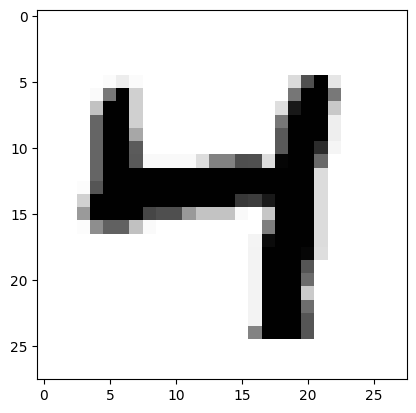

In [38]:
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

IndexError: index 2 is out of bounds for dimension 0 with size 2

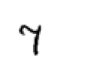

In [39]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
sg_criterion = nn.MSELoss(reduction = 'sum')

In [ ]:
input_size = 784
hidden_size = 256
hidden_size_syn = 1024
output_size = 10
learning_rate = 3e-5

In [ ]:
def optimization(model, learning_rate = learning_rate):
    optimizer = optim.SGD(model.parameters(), lr = learning_rate)
    return optimizer

# Adding Batch Normalization

In [ ]:
class network(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(network, self).__init__()
        
        self.layer = nn.Sequential(nn.Linear(input_dim, output_dim),
                                   nn.BatchNorm1d(output_dim),
                                   nn.ReLU())

In [ ]:
class syn_network(nn.Module):
    def __init__(self, hidden_dim, syn_hid_dim = 1024):
        super(syn_network, self).__init__()

        # dni network
        self.layer = nn.Sequential(nn.Linear(hidden_dim, syn_hid_dim),
           nn.BatchNorm1d(syn_hid_dim),
           nn.ReLU(),
           nn.Linear(syn_hid_dim, syn_hid_dim),
           nn.BatchNorm1d(syn_hid_dim),
           nn.ReLU(),
           nn.Linear(syn_hid_dim, hidden_dim))

In [ ]:
def optimization(model, learning_rate = learning_rate):
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    return optimizer

In [ ]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        m.weight.data.fill_(0.0)
        m.bias.data.fill_(0.0)

In [ ]:
class Hook():
    def __init__(self, module, backward = False):
        if backward == False:
            self.hook = module.register_forward_hook(self.hook_activations)
        else:
            self.hook = module.register_full_backward_hook(self.hook_gradients)
            
    def hook_activations(self, module, inputs, outputs):
        self.outputs = outputs
        
    def hook_gradients(self, module, grad_input, grad_output):
        self.grad_output = grad_output
        
    def hook_close(self):
        self.hook.remove()

In [ ]:
def training_syn(model_syn, sg_criterion, g_pred, z, optimizer_syn):
    model_syn.train()
    optimizer_syn.zero_grad()
    loss = sg_criterion(g_pred, z.clone().detach())
    loss.backward()
    optimizer_syn.step()
    model_syn.eval()
    return model_syn

In [ ]:
def backward_update_syntarget(h, model_layer, model_syn, hook_gradients_i, pre_sg = False):
    g_sg = model_syn(h.clone().detach())
    h.backward(g_sg.clone().detach())
    z_pre = None
    if pre_sg:
        grad_ln = hook_gradients_i.grad_output[0]
        z_pre = torch.matmul(grad_ln.detach().clone(), model_layer[0].weight.clone().detach())
    return g_sg, z_pre

In [ ]:
def test(models, device, testloader, epoch, results):
    print_threshold = 1
    store_threshold = 1
    model_test = nn.Sequential(models[0].layer, models[1].layer, models[2].layer, 
                               models[3].layer, models[4].layer, models[5].layer)
    model_test.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for images, target in testloader:
            images, target = images.to(device), target.to(device)
            images = images.view(images.shape[0], -1)
            if images.shape[0] != 256:
                    continue
            output = model_test(images)
            test_loss = torch.nn.functional.nll_loss(output, target, reduction = 'sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            
    test_loss/= len(testloader.dataset)

    for i in [round(test_loss,6), round(100.0*correct/len(testloader.dataset),4), round(100-100. * correct / len(testloader.dataset),4)]:
        results.append(str(i))

    if print_threshold != False:
        if epoch % print_threshold == 0:
            print("Test loss: {:.6f} | Test Accuracy: {}/{} ({:.4f}%)\n".format(
            test_loss, correct, len(testloader.dataset),
            100. * correct / len(testloader.dataset)))

In [ ]:
def train(models, syn_models, device, trainloader, optimizers, optimizers_syn, criterion, sg_criterion, epoch, hook_gradients, results):

    print_threshold = 1
    store_threshold = 1
    eps = 1e-5
    training_loss = 0
        
    for module in models:
        module.train()

    for batch_idx, (images, labels) in enumerate(trainloader):
        images, labels = images.to(device), labels.to(device)
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
        if images.shape[0] != 256:
                continue

        # Training pass
        for opt in optimizers:
            opt.zero_grad()

        # feed forward layer0 and update by g_sg
        h0 = models[0].layer(images)
        g_sg0, _ = backward_update_syntarget(h0, models[0].layer, syn_models[0].layer, hook_gradients[0], pre_sg = False)
        optimizers[0].step()
        #####
        
        # feed forward layer1 and update by g_sg
        h1 = models[1].layer(h0.clone().detach().requires_grad_(True))
        g_sg1, z0 = backward_update_syntarget(h1, models[1].layer, syn_models[1].layer, hook_gradients[1], pre_sg = True)
        optimizers[1].step()
        # train previous layer synthetic model
        syn_models[0].layer = training_syn(syn_models[0].layer, sg_criterion, g_sg0, z0, optimizers_syn[0])
        #####
        
        # feed forward layer2 and update by g_sg
        h2 = models[2].layer(h1.clone().detach().requires_grad_(True))
        g_sg2, z1 = backward_update_syntarget(h2, models[2].layer, syn_models[2].layer, hook_gradients[2], pre_sg = True)
        optimizers[2].step()
        # train previous layer synthetic model
        syn_models[1].layer = training_syn(syn_models[1].layer, sg_criterion, g_sg1, z1, optimizers_syn[1])
        #####
        
        # feed forward layer3 and update by g_sg
        h3 = models[3].layer(h2.clone().detach().requires_grad_(True))
        g_sg3, z2 = backward_update_syntarget(h3, models[3].layer, syn_models[3].layer, hook_gradients[3], pre_sg = True)
        optimizers[3].step()
        # train previous layer synthetic model
        syn_models[2].layer = training_syn(syn_models[2].layer, sg_criterion, g_sg2, z2, optimizers_syn[2])
        #####
        
        # feed forward layer4 and update by g_sg
        h4 = models[4].layer(h3.clone().detach().requires_grad_(True))
        g_sg4, z3 = backward_update_syntarget(h4, models[4].layer, syn_models[4].layer, hook_gradients[4], pre_sg = True)
        optimizers[4].step()
        # train previous layer synthetic model
        syn_models[3].layer = training_syn(syn_models[3].layer, sg_criterion, g_sg3, z3, optimizers_syn[3])
        #####

        # feed forward layer 5 and backprop / update layer 5
        h5 = models[5].layer(h4.clone().detach().requires_grad_(True))
        loss = criterion(h5, labels)
        loss.backward()
        grad_ln5 = hook_gradients[5].grad_output[0]
        z4 = torch.matmul(grad_ln5.detach().clone(), models[5].layer[0].weight.clone().detach())
        optimizers[5].step()

        syn_models[4].layer = training_syn(syn_models[4].layer, sg_criterion, g_sg4, z4, optimizers_syn[4])

        training_loss += loss.item()
        training_loss_norm = training_loss/len(trainloader)

    for i in [epoch, round(training_loss_norm,6)]:
        results.append(str(i))

    if print_threshold != False:
        if epoch % print_threshold == 0:
            print("Epoch {} \nTraining loss: {}".format(epoch, training_loss_norm))

In [ ]:
def main():
    model_version = 'FC_FD_MNIST_V01'
    print_threshold = 1
    store_threshold = 1
    if print_threshold != False:
        print(time.asctime(), f' {model_version} execution started...')
    input_size = 784
    hidden_size = 256
    hidden_size_syn = 1024
    output_size = 10
    batch_size = 256
    epochs = 2000
    
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    print('Device: ', device.type, '\n')
    
    train_kwargs = {'batch_size': batch_size, 'shuffle': True}
    test_kwargs = {'batch_size': batch_size, 'shuffle': True}
    if use_cuda:
        cuda_kwargs = {'num_workers': 1,
                   'pin_memory': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)
        
    transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.1307,), (0.3081,)),
                              ])
    trainset = datasets.MNIST('./PATH_TO_STORE_TRAINSET', download=True, train=True, transform=transform)
    testset = datasets.MNIST('./PATH_TO_STORE_TESTSET', download=True, train=False, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, **train_kwargs)
    testloader = torch.utils.data.DataLoader(testset, **test_kwargs)

    criterion = nn.CrossEntropyLoss()
    sg_criterion = nn.MSELoss(reduction = 'sum')
    
    syn_models, optimizers_fc, optimizers_syn = [], [], []
    
    # building models
    fc_models = [network(input_size, hidden_size).to(device), network(hidden_size, hidden_size).to(device), 
             network(hidden_size, hidden_size).to(device), network(hidden_size, hidden_size).to(device),
             network(hidden_size, hidden_size).to(device), network(hidden_size, output_size).to(device)]

    for i in range(5):
        syn_models.append(syn_network(hidden_size).to(device))
        
    for syn_model in syn_models:
        syn_model.apply(init_weights)
        
    # setting optimizers    
    for fc_model in fc_models:
        optimizers_fc.append(optimization(fc_model))
        
    for syn_model in syn_models:
        optimizers_syn.append(optimization(syn_model))
    
    # setting hooks
    hook_gradients = [Hook(model.layer[0], backward = True) for model in fc_models]
    
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizers_fc[5], milestones=[3e5, 4e5], gamma = 0.1)

    with open(f'./results_{model_version}.csv', 'w', newline='') as f:
        f.write("epoch, training_loss, test_loss, test_accuracy, test_error, timestamp, run_time\n")

    time0 = time.time()
    for epoch in range(1, epochs+1):
        results = []
        results_syn = []
        train(fc_models, syn_models, device, trainloader, optimizers_fc, optimizers_syn, criterion, sg_criterion, epoch, hook_gradients, results)
        test(fc_models, device, testloader, epoch, results)
        scheduler.step()
        if epoch % store_threshold == 0:
            results.append(time.asctime())
            results.append(round((time.time()-time0)/60, 6))
            if epoch % store_threshold*1000 == 0:
                fc_models_state = []
                for module in fc_models:
                    fc_models_state.append(module.state_dict())
                syn_models_state = []
                for module in syn_models:
                    syn_models_state.append(module.state_dict())
                torch.save(fc_models_state, f'./model_{model_version}.pt')
                torch.save(syn_models_state, f'./model_syn_{model_version}.pt')
            with open(f'./results_{model_version}.csv', 'a', newline='') as file:
                writer = csv.writer(file)
                writer.writerow(results)
    if print_threshold != False:
        print("\nTraining Time (in minutes) =",(time.time()-time0)/60, "\nEnd Time:", time.asctime(), "\nEpochs:", epochs)


In [ ]:
main()

In [ ]:
fc_models = [network(input_size, hidden_size).to(device), network(hidden_size, hidden_size).to(device), 
         network(hidden_size, hidden_size).to(device), network(hidden_size, hidden_size).to(device),
         network(hidden_size, hidden_size).to(device), network(hidden_size, output_size).to(device)]

In [ ]:
for module in fc_models:
    module.train()

In [ ]:
fc_models_state = []
for module in fc_models:
    fc_models_state.append(module.state_dict())

In [ ]:
syn_models_state = []
for module in syn_models:
    syn_models_state.append(module.state_dict())

In [ ]:
hook_gradients = [Hook(model.layer[0], backward = True) for model in fc_models]

In [ ]:
for i in fc_models:
    print(i.layer)

### Testing Manually

In [ ]:
input_size = 784
hidden_size = 256
hidden_size_syn = 1024
output_size = 10
learning_rate = 3e-5

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
sg_criterion = nn.MSELoss(reduction = 'sum')

In [ ]:
model0 = network(784, 256)

In [ ]:
model1 = network(256, 256)

In [ ]:
model2 = network(256, 10)

In [ ]:
models = [model0, model1, model2]

In [ ]:
optimizer0 = optimization(model0, learning_rate=0.001)

In [ ]:
optimizer1 = optimization(model1, learning_rate=0.001)

In [ ]:
optimizer2 = optimization(model2, learning_rate=0.001)

In [ ]:
optimizers = [optimizer0, optimizer1, optimizer2]

In [ ]:
model_syn0 = syn_network(256)

In [ ]:
model_syn1 = syn_network(256)

In [ ]:
model_syn2 = syn_network(256)

In [ ]:
syn_models = [model_syn0, model_syn1, model_syn2]

In [ ]:
optimizer_syn0 = optimization(model_syn0, learning_rate=0.001)

In [ ]:
optimizer_syn1 = optimization(model_syn1, learning_rate=0.001)

In [ ]:
optimizer_syn2 = optimization(model_syn2, learning_rate=0.001)

In [ ]:
optimizers_syn = [optimizer_syn0, optimizer_syn1, optimizer_syn2]

In [ ]:
model_syn0.apply(init_weights)

In [ ]:
model_syn1.apply(init_weights)

In [ ]:
model_syn2.apply(init_weights)

In [ ]:
hook_gradients = [Hook(layer[0], backward = True) for layer in [model0.layer, model1.layer, model2.layer]]

In [ ]:
images, labels = dataiter.next()
images = images.view(images.shape[0], -1)

### With images as input

In [ ]:
for opt in optimizers:
    opt.zero_grad()

In [ ]:
images.shape

In [ ]:
y = labels

In [ ]:
models[0].layer[0].weight

In [ ]:
h0 = models[0].layer(images)

In [ ]:
hook_gradients[1].grad_output[0]

In [ ]:
models[0].layer[0].weight.grad

In [ ]:
g_sg0 = model_syn0.layer(h0.clone().detach().requires_grad_(True))

In [ ]:
g_sg0

In [ ]:
g_sg0, _ = backward_update_syntarget(h0, models[0].layer, syn_models[0].layer, hook_gradients[0], pre_sg = False)

In [ ]:
g_sg0

In [ ]:
optimizers[0].step()

In [ ]:
hook_gradients[1].grad_output[0]

In [ ]:
h1 = models[1].layer(h0.clone().detach())

In [ ]:
g_sg1, z0 = backward_update_syntarget(h1, models[1].layer, syn_models[1].layer, hook_gradients[1], pre_sg = True)

In [ ]:
optimizers[1].step()

In [ ]:
syn_models[0].layer = training_syn(syn_models[0].layer, sg_criterion, g_sg0, z0, optimizers_syn[0])

In [ ]:
h2 = models[2].layer(h1.clone().detach().requires_grad_(True))

In [ ]:
loss = criterion(h2, labels)

In [ ]:
loss.backward()

In [ ]:
grad_ln2 = hook_gradients[2].grad_output[0]

In [ ]:
z1 = torch.matmul(grad_ln2.detach().clone(), models[2].layer[0].weight.clone().detach())

In [ ]:
optimizers[2].step()

In [ ]:
syn_models[1].layer = training_syn(syn_models[1].layer, sg_criterion, g_sg1, z1, optimizers_syn[1])

In [ ]:
# feed forward layer 5 and backprop / update layer 5
h5 = model.layer5(h4.clone().detach().requires_grad_(True))
loss = criterion(h5, labels)
loss.backward()
grad_ln5 = hook_gradients[5].grad_output[0]
z4 = torch.matmul(grad_ln5.detach().clone(), model.layer5[0].weight.clone().detach())
optimizer5.step()

model_syn4 = training_syn(model_syn4, sg_criterion, g_sg4, z4, optimizer_syn4)

In [ ]:
def backward_update_syntarget(h, model_layer, model_syn, hook_gradients_i, pre_sg = False):
    g_sg = model_syn(h.clone().detach())
    h.backward(g_sg.clone().detach())
    z_pre = None
    if pre_sg:
        grad_ln = hook_gradients_i.grad_output[0]
        z_pre = torch.matmul(grad_ln.detach().clone(), model_layer[0].weight.clone().detach())
    return g_sg, z_pre

In [ ]:
model_syn0 = training_syn(syn_models[0], sg_criterion, g_sg0, z0, optimizer_syn0)

In [ ]:
        # feed forward layer1 and update by g_sg
        h1 = model.layer1(h0.clone().detach().requires_grad_(True))
        z0, g_sg1 = backward_update_syntarget(h1, model.layer1, model_syn1, hook_gradients[1])
        optimizer1.step()
        
        model_syn0 = training_syn(model_syn0, sg_criterion, g_sg0, z0, optimizer_syn0)

In [ ]:
h4.backward(g_sg4)

In [ ]:
h5 = model.layer5(h4.clone().detach().requires_grad_(True))

In [ ]:
h6 = model.layer6(h5)

In [ ]:
loss = criterion(h6, y)

In [ ]:
loss.backward()

In [ ]:
model.layer4[0].weight.shape

In [ ]:
gb5 = hook_gradients[0].grad_output[0]

In [ ]:
gb5.shape

In [ ]:
mu5 = hook_activations[1].outputs

In [ ]:
optimizer.step()

In [ ]:
dh5_dh4 = deriv_act_aft_pre(model.layer5[0].weight, mu5, h5, eps, model.layer5[1].weight)

In [ ]:
dh5_dh4.shape

In [ ]:
mu5 = mu5.clone().detach()

In [ ]:
weight5 = model.layer5[0].weight.clone().detach(); weight5

In [ ]:
weight5.shape

In [ ]:
h_out = h5.clone().detach()

In [ ]:
gamma5 = model.layer5[1].weight.clone().detach()

In [ ]:
model.layer5[1]

In [ ]:
gamma5.shape

In [ ]:
mu5.shape

In [ ]:
m = mu5.shape[0]

In [ ]:
m

In [ ]:
mu5.shape

In [ ]:
batch_mean = torch.mean(mu5, dim = 0)

In [ ]:
batch_mean.shape

In [ ]:
batch_var = ((mu5 - batch_mean)**2).sum(dim = 0)/m

In [ ]:
mu_var = torch.var(mu5, dim = 0, unbiased = False)

In [ ]:
mu_var.shape

In [ ]:
part1 = (1 - 1/m) / torch.sqrt(mu_var + eps)

In [ ]:
part1.shape

In [ ]:
h_out[h_out > 0.0] = 1.0

In [ ]:
h_out.shape

In [ ]:
gamma5.shape

In [ ]:
gamma5

In [ ]:
part1

In [ ]:
def running_mean_var(x, mean, var, epoch):
    mean = mean * (epoch -1)/epoch + torch.mean(x, dim = 0)/epoch #New average = old average * (n-1)/n + new value /n
    var = var * (epoch -1)/epoch + torch.var(x, dim = 0, unbiased = False)/epoch
    
    return mean, var

In [ ]:
running_mean, running_var = running_mean_var(mu5, batch_mean, batch_var, 1)

In [ ]:
bn_param = {'mode': 'train', 'eps': 1e-5, 'momentum': 0.1, 'running_mean': running_mean, 'running_var': running_var}

In [ ]:
(h_out * gamma5 * part1).shape

In [ ]:
weight5.shape

In [ ]:
(h_out * gamma5 * part1) * weight5

In [ ]:
torch.matmul((h_out * gamma5 * part1) , weight5.T)

In [ ]:
linear_t = nn.Linear(256, 256)

In [ ]:
h_out

In [ ]:
h_t = linear_t(h_out)

In [ ]:
h_t.shape

In [ ]:
h_t

In [ ]:
weight_t = linear_t.weight

In [ ]:
bias_t = linear_t.bias

In [ ]:
weight_t.shape

In [ ]:
torch.matmul(h_out, weight_t.T) + bias_t

In [ ]:
gb5.shape

In [ ]:
dh5_dh4.shape

In [ ]:
z4 = torch.mul(gb5, dh5_dh4)

In [ ]:
model_syn4 = training_syn(model_syn4, sg_criterion, h4, z4, optimizer_syn)

In [ ]:
model.layer4[1]

In [ ]:
hook_activations[0].outputs

### Manual from scratch

In [ ]:
linear1 = nn.Linear(2,2)

In [ ]:
batch_norm1 = nn.BatchNorm1d(2, eps = 0, affine = False,track_running_stats = False, momentum = 0.0)

In [ ]:
linear2 = nn.Linear(2,2)

In [ ]:
hook_activations = [Hook(linear1), Hook(linear2)]

In [ ]:
hook_gradients = [Hook(linear1, backward = True),Hook(linear2, backward = True)]

In [ ]:
optimizer1 = optim.SGD(nn.Sequential(linear1, batch_norm1).parameters(), lr = 0.1)

In [ ]:
optimizer2 = optim.SGD(linear2.parameters(), lr = 0.1)

In [ ]:
optimizer_a = optim.SGD(nn.Sequential(linear1, linear2).parameters(), lr = 0.1)

In [ ]:
with torch.no_grad():
    linear1.weight[0] = torch.tensor([0.1, 0.2])
    linear1.weight[1] = torch.tensor([0.3, 0.4])
    linear1.bias[0] = 0.1
    linear1.bias[1] = 0.3
    linear2.weight[0] = torch.tensor([0.5, 0.6])
    linear2.weight[1] = torch.tensor([0.7, 0.8])
    linear2.bias[0] = 0.2
    linear2.bias[1] = 0.4

In [ ]:
linear1.weight

In [ ]:
linear1.bias

In [ ]:
linear2.weight

In [ ]:
x = torch.tensor([[4., 0.5], [1., 3.]], requires_grad=True)

In [ ]:
x.shape

In [ ]:
mu = linear1(x); mu

In [ ]:
hook_activations[0].outputs

In [ ]:
h1 = batch_norm1(mu)

In [ ]:
#optimizer1.step()

In [ ]:
mu2 = linear2(h1.clone().detach())
print(mu2)

In [ ]:
# mu2 = linear2(h1)
# print(mu2)

In [ ]:
target = torch.tensor([[2.3, 1.0], [0.4, 0.8]])

In [ ]:
criterion = nn.MSELoss(reduction='mean')

In [ ]:
loss = criterion(mu2, target)

In [ ]:
loss.backward()

In [ ]:
grad2_bw = hook_gradients[1].grad_output[0]
print(grad2_bw)

In [ ]:
dL_dh1 = torch.matmul(grad2_bw, linear2.weight)
print(dL_dh1)

In [ ]:
dL_dw2 = torch.matmul(grad2_bw.T, h1)
print(dL_dw2)

In [ ]:
# weight update
linear2_updated_w = linear2.weight - 0.1* dL_dw2
print(linear2_updated_w)

#### finding dh1_dmu1

In [ ]:
#mu = grad2_bw

In [ ]:
m = mu.shape[0]; m

In [ ]:
sqrt_var = torch.sqrt(torch.var(mu, unbiased = False, axis = 0)); sqrt_var

In [ ]:
part1 = (1-1/m)/sqrt_var; part1

In [ ]:
mu

In [ ]:
sigx = torch.sum(mu, axis = 0); sigx

In [ ]:
part2a = 1/m - 2*sigx/(m**2); part2a

In [ ]:
part2b = mu - 1/m * (sigx); part2b

In [ ]:
part2_top = torch.matmul(part2a, part2b); part2_top

In [ ]:
part2 = part2_top/(2.0*torch.pow(torch.var(mu, unbiased = False, axis = 0), 1.5))

In [ ]:
part2

In [ ]:
dh1_dmu1 = part1 - part2; dh1_dmu1

In [ ]:
dL_dh1

In [ ]:
dL_dmu1 = torch.matmul(dL_dh1, dh1_dmu1); dL_dmu1

In [ ]:
optimizer2.step()

In [ ]:
linear2.weight

In [ ]:
#grad1_manual = dL_dh1 * dh1_dmu1

In [ ]:
mu.backward(grad1_manual)

In [ ]:
# grad1 to be calculated manually
grad1_bw = hook_gradients[0].grad_output[0]
print(grad1_bw)

In [ ]:
dL_dw1 = torch.matmul(grad1_bw.T, x)
print(dL_dw1)

In [ ]:
# weight update
linear1_updated_w = linear1.weight - 0.1* dL_dw1
print(linear1_updated_w)

In [ ]:
optimizer1.step()

In [ ]:
linear1_updated_w = linear1.weight
print(linear1_updated_w)

In [ ]:
linear1.weight

In [ ]:
#optimizer_a.step()

In [ ]:
#batch_norm = nn.BatchNorm1d(2, eps = 0, affine = False,track_running_stats = False, momentum = 0.0)

In [ ]:
#batch_norm = nn.BatchNorm1d(4, eps = 1e-3)

In [ ]:
relu = nn.ReLU()

In [ ]:
syn = syn_network(4)

In [ ]:
batch_norm.weight

In [ ]:
batch_norm.bias

In [ ]:
inp = torch.tensor([[1.0, 0.0, 5.0, 9.0], [22.0, 3.0, 4.0, 7.0], [2.0, 23.0, 42.0, 7.0]])

In [ ]:
inp = torch.tensor([[10.0, 0.0, 50.0, 90.0], [20.0, 43.0, 4.0, 40.0], [-20.0, 3.0, -44.0, 270.0]])

In [ ]:
inp = torch.tensor([[13.0, 0.0, -30.0, 90.0], [-4.0, 3.0, -4.0, 4.0],[1.0, 0.0, 5.0, 9.0]])

In [ ]:
#mu = linear(inp)

In [ ]:
mu

In [ ]:
norm_out = batch_norm(mu)

In [ ]:
norm_out

In [ ]:
relu_out = relu(norm_out)

In [ ]:
relu_out

In [ ]:
gamma = batch_norm.weight; gamma

In [ ]:
g_sg = syn(relu_out.clone().detach().requires_grad_(True))

#### optimizer

In [ ]:
model = nn.Sequential(linear, batch_norm, relu)

In [ ]:
optimizer = optimization(model, learning_rate=0.01)

In [ ]:
optimizer.param_groups

In [ ]:
optimizer.zero_grad()

In [ ]:
dL_dw = loss_grad(inp, relu_out, mu, g_sg, eps, gamma)

In [ ]:
dL_dw

In [ ]:
weight_before = linear.weight.clone().detach(); weight_before

In [ ]:
linear.weight.grad

In [ ]:
relu_out.backward(dL_dw.clone().detach())

In [ ]:
relu_out

In [ ]:
linear.weight.grad

In [ ]:
optimizer.step()

In [ ]:
optimizer.param_groups

In [ ]:
weight_after = linear.weight.clone().detach(); weight_after

In [ ]:
print(weight_before == weight_after)

In [ ]:
optimizer.zero_grad()

In [ ]:
target = torch.tensor([0, 1, 1, 0])

In [ ]:
loss = criterion(h2, target)

In [ ]:
loss

In [ ]:
loss.backward()

In [ ]:
print(linear.weight.grad)

### From https://stackoverflow.com/questions/67968913/derivative-of-batchnorm2d-in-pytorch

In [ ]:
class network_1st(nn.Module):
    def __init__(self, channel_in, channel_out, conv_kernel_size = 1, pooling_kernel_size = 1):
        super(network_1st, self).__init__()
               
        self.conv2d = nn.Conv2d(channel_in, channel_out, kernel_size=conv_kernel_size)
        self.batchnorm2d = nn.BatchNorm2d(channel_out)
        
    def forward(self, x):
        mu = self.conv2d(x)
        out = self.batchnorm2d(mu)
        
        return mu, out


In [ ]:
images, labels = dataiter.next()
#images = images.view(images.shape[0], -1)

In [ ]:
images = torch.rand(1, 1, 5, 5)

In [ ]:
target = torch.rand(1, 1, 5, 5)

In [ ]:
model = network_1st(1, 1)

In [ ]:
hook_gradients = [Hook(model.batchnorm2d, backward = True) for model in [model]]

In [ ]:
mu, out = model(images)

In [ ]:
#criterion = nn.MSELoss(reduction='mean')

In [ ]:
#loss = criterion(out, target)

In [ ]:
loss = abs(target - out)

In [ ]:
out.backward(loss)

In [ ]:
grad_backward = hook_gradients[0].grad_output[0]

In [ ]:
def backward_batchnorm2d(input, output, grad_output, layer):
    gamma = layer.weight
    gamma = gamma.view(1,-1,1,1) # edit
    # beta = layer.bias
    # avg = layer.running_mean
    # var = layer.running_var
    eps = layer.eps
    B = input.shape[0] * input.shape[2] * input.shape[3] # edit

    # add new
    mean = input.mean(dim = (0,2,3), keepdim = True)
    variance = input.var(dim = (0,2,3), unbiased=False, keepdim = True)
    x_hat = (input - mean)/(torch.sqrt(variance + eps))
    
    dL_dxi_hat = grad_output * gamma
    # dL_dvar = (-0.5 * dL_dxi_hat * (input - avg) / ((var + eps) ** 1.5)).sum((0, 2, 3), keepdim=True) 
    # dL_davg = (-1.0 / torch.sqrt(var + eps) * dL_dxi_hat).sum((0, 2, 3), keepdim=True) + dL_dvar * (-2.0 * (input - avg)).sum((0, 2, 3), keepdim=True) / B
    dL_dvar = (-0.5 * dL_dxi_hat * (input - mean)).sum((0, 2, 3), keepdim=True)  * ((variance + eps) ** -1.5) # edit
    dL_davg = (-1.0 / torch.sqrt(variance + eps) * dL_dxi_hat).sum((0, 2, 3), keepdim=True) + (dL_dvar * (-2.0 * (input - mean)).sum((0, 2, 3), keepdim=True) / B) #edit
    
    dL_dxi = (dL_dxi_hat / torch.sqrt(variance + eps)) + (2.0 * dL_dvar * (input - mean) / B) + (dL_davg / B) # dL_dxi_hat / sqrt()
    # dL_dgamma = (grad_output * output).sum((0, 2, 3), keepdim=True) 
    dL_dgamma = (grad_output * x_hat).sum((0, 2, 3), keepdim=True) # edit
    dL_dbeta = (grad_output).sum((0, 2, 3), keepdim=True)
    return dL_dxi, dL_dgamma, dL_dbeta

In [ ]:
dL_dxi, dL_dgamma, dL_dbeta = backward_batchnorm2d(images, out, loss, model.batchnorm2d)

In [ ]:
grad_backward

In [ ]:
dL_dxi

### 1D Batch Norm

In [ ]:
class network_1d(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(network_1d, self).__init__()
               
        self.batchnorm1d = nn.BatchNorm1d(output_dim)

        
    def forward(self, x):
        out = self.batchnorm1d(x)
        
        return out


In [ ]:
#images, labels = dataiter.next()
#images = images.view(images.shape[0], -1)

In [ ]:
#images = torch.rand(2, 1, 3, 3, requires_grad = True)

In [ ]:
#images = images.view(images.shape[0], -1)

In [ ]:
images = torch.tensor([[0.7, 0.1, -1.3, 1.1, 0.5, 0.3, .6, -0.6, 0.2],
        [0.7, 0.3, 0.1, 0.6, 0.8, 0.9, 0.5, 2., 0.0]], requires_grad = True)

In [ ]:
target = torch.tensor([[0.9, 0.2, -1.2, 1.0, 0.4, 0.8, 0.4, -0.1, 0.9],
        [0.4, 0.2, 0.3, 0.6, 0.5, 0.6, 0.1, 2.4, 0.1]], requires_grad = True)

In [ ]:
images.shape

In [ ]:
model = network_1d(9, 9)

In [ ]:
gamma = torch.tensor([0.9, 1., 0.89, 0.92, 1., 1., 0.96, 1., 0.94], requires_grad=True)

In [ ]:
model.batchnorm1d.weight = torch.nn.Parameter(gamma)

In [ ]:
beta = torch.tensor([0.0, 0.1, 0.0, 0.0, 0.05, 0.06, 0.0, 0.03, 0.0], requires_grad=True)

In [ ]:
model.batchnorm1d.bias = torch.nn.Parameter(beta)

In [ ]:
hook_gradients = [Hook(model.batchnorm1d, backward = True) for model in [model]]

In [ ]:
y_pred = model(images)

In [ ]:
images

In [ ]:
target

In [ ]:
y_pred

In [ ]:
grad_y_pred = 2*(y_pred - target)

In [ ]:
grad_y_pred

In [ ]:
loss = (y_pred - target).pow(2).sum()
loss.item()

In [ ]:
loss.backward()

In [ ]:
grad_backward = hook_gradients[0].grad_output[0]

In [ ]:
grad_backward

In [ ]:
print(images.grad)

In [ ]:
model.batchnorm1d.weight.grad

In [ ]:
def tensor_status(**kwargs):
    print("\n")
    for arg_name in kwargs:
        t= kwargs[arg_name]
        t_name=arg_name
    print("Status of tensor "+t_name+":\n")
    print("==============")
    print("Data: "+str(t.data))
    print("grad: "+str(t.grad) if t.is_leaf else str(None))
    print("grad_fn: "+str(t.grad_fn))
    print("is_leaf: "+str(t.is_leaf))
    print("requires_grad:"+str(t.requires_grad))
    print("==============\n")
    return ""

In [ ]:
tensor_status(y_pred = y_pred)

#### Comp Graph

In [ ]:
back_fn = y_pred.grad_fn

In [ ]:
back_fn.next_functions[0][0]

In [ ]:
def print_graph(g, level=0):
    if g == None: return
    print('*'*level*4, g)
    for subg in g.next_functions:
        print_graph(subg[0], level+1)

In [ ]:
print_graph(y_pred.grad_fn)

### Manual Batchnorm

In [ ]:
def batchnorm_forward(x, gamma, beta, eps):

    N, D = x.shape

    #step1: calculate mean
    mu = 1./N * torch.sum(x, dim = 0)

    #step2: subtract mean vector of every trainings example
    xmu = x - mu

    #step3: following the lower branch - calculation denominator
    sq = xmu ** 2

    #step4: calculate variance
    var = 1./N * torch.sum(sq, dim = 0)

    #step5: add eps for numerical stability, then sqrt
    sqrtvar = torch.sqrt(var + eps)

    #step6: invert sqrtwar
    ivar = 1./sqrtvar

    #step7: execute normalization
    xhat = xmu * ivar

    #step8: Nor the two transformation steps
    gammax = gamma * xhat

    #step9
    out = gammax + beta

    #store intermediate
    cache = (xhat,gamma,xmu,ivar,sqrtvar,var,eps)

    return out, cache

In [ ]:
images = torch.tensor([[0.7, 0.1, -1.3, 1.1, 0.5, 0.3, .6, -0.6, 0.2],
        [0.7, 0.3, 0.1, 0.6, 0.8, 0.9, 0.5, 2., 0.0]], requires_grad = True)

In [ ]:
gamma = torch.tensor([0.9, 1., 0.89, 0.92, 1., 1., 0.96, 1., 0.94], requires_grad=True)

In [ ]:
beta = torch.tensor([0.0, 0.1, 0.0, 0.0, 0.05, 0.06, 0.0, 0.03, 0.0], requires_grad=True)

In [ ]:
eps = 1e-5

In [ ]:
man_out, cache = batchnorm_forward(images, gamma, beta, eps)

In [ ]:
cache

In [ ]:
print_graph(man_out.grad_fn)

In [ ]:
man_out

In [ ]:
y_pred

In [ ]:
def batchnorm_backward(dout, cache):

    #unfold the variables stored in cache
    xhat,gamma,xmu,ivar,sqrtvar,var,eps = cache

    #get the dimensions of the input/output
    N,D = dout.shape

    #step9
    dbeta = torch.sum(dout, dim=0)
    dgammax = dout #not necessary, but more understandable

    #step8
    dgamma = torch.sum(dgammax*xhat, dim=0)
    dxhat = dgammax * gamma

    #step7
    divar = torch.sum(dxhat*xmu, dim=0)
    dxmu1 = dxhat * ivar

    #step6
    dsqrtvar = -1. /(sqrtvar**2) * divar

    #step5
    dvar = 0.5 * 1. /torch.sqrt(var+eps) * dsqrtvar

    #step4
    dsq = 1. /N * torch.ones((N,D)) * dvar

    #step3
    dxmu2 = 2 * xmu * dsq

    #step2
    dx1 = (dxmu1 + dxmu2)
    dmu = -1 * torch.sum(dxmu1+dxmu2, dim=0)

    #step1
    dx2 = 1. /N * torch.ones((N,D)) * dmu

    #step0
    dx = dx1 + dx2

    return dx, dgamma, dbeta

In [ ]:
batchnorm_backward(grad_y_pred, cache)

In [ ]:
images.grad

In [ ]:
model.batchnorm1d.weight.grad

In [ ]:
model.batchnorm1d.bias.grad

### Manual Linear

In [ ]:
class network_linear(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(network_linear, self).__init__()
               
        self.linear = nn.Linear(input_dim, output_dim)

        
    def forward(self, x):
        out = self.linear(x)
        
        return out

In [ ]:
def linear_backward(dout, cache):
    x, weight = cache
    
    dw = torch.matmul(dout.T, x)
    db = dout.sum(dim = 0)
    dx = torch.matmul(dout, weight)
    return dx, dw, db

In [ ]:
model = network_linear(9, 9)

In [ ]:
images.shape

In [ ]:
images.grad.zero_()

In [ ]:
model.linear.weight

In [ ]:
hook_gradients_linear = [Hook(model.linear, backward = True) for model in [model]]

In [ ]:
y_linear_pred = model(images)

In [ ]:
y_linear_pred

In [ ]:
loss_linear = (y_linear_pred - target).pow(2).sum(); loss_linear

In [ ]:
loss_linear.backward()

In [ ]:
linear_grad_backward = hook_gradients_linear[0].grad_output[0]

In [ ]:
linear_grad_backward

In [ ]:
model.linear.weight.grad

In [ ]:
model.linear.bias.grad

In [ ]:
dL_dout_linear = 2*(y_linear_pred - target); dL_dout_linear

In [ ]:
dL_db = dL_dout_linear.sum(dim = 0); dL_db

In [ ]:
dL_dw_linear = torch.matmul(dL_dout_linear.T, images); dL_dw_linear

In [ ]:
images.grad

In [ ]:
dL_dx = torch.matmul(dL_dout_linear, model.linear.weight); dL_dx

In [ ]:
# by function

In [ ]:
cache = images, model.linear.weight

In [ ]:
linear_backward(dL_dout_linear, cache)

### Manual ReLu

In [ ]:
class network_relu(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(network_relu, self).__init__()
               
        self.relu = nn.ReLU()

        
    def forward(self, x):
        out = self.relu(x)
        
        return out

In [ ]:
def relu_backward(dout, x):
    x = x.clone()
    x[x > 0.0] = 1.0
    x[x <= 0.0] = 0.0
    dx = torch.mul(dout, x)
    return dx

In [ ]:
model = network_relu(9, 9)

In [ ]:
images.grad.zero_()

In [ ]:
images.shape

In [ ]:
hook_gradients_relu = [Hook(model.relu, backward = True) for model in [model]]

In [ ]:
y_relu_pred = model(images)

In [ ]:
y_relu_pred

In [ ]:
loss_relu = (y_relu_pred - target).pow(2).sum(); loss_relu

In [ ]:
loss_relu.backward()

In [ ]:
relu_grad_backward = hook_gradients_relu[0].grad_output[0]; relu_grad_backward

In [ ]:
dL_dout_relu = 2*(y_relu_pred - target); dL_dout_relu

In [ ]:
model.relu

In [ ]:
images.grad

In [ ]:
relu_backward(dL_dout_relu, images)

### Manual Conv2d

In [ ]:
class network_conv2d(nn.Module):
    def __init__(self, channel_in, channel_out, kernel_size, padding):
        super(network_conv2d, self).__init__()
               
        self.conv2d = nn.Conv2d(channel_in, channel_out, kernel_size=kernel_size, padding = padding)

        
    def forward(self, x):
        out = self.conv2d(x)
        
        return out

In [ ]:
def conv2d_backward(dout, cache):

    return dx, dw, db

In [ ]:
def linear_backward(dout, cache):
    x, weight = cache
    
    dw = torch.matmul(dout.T, x)
    db = dout.sum(dim = 0)
    dx = torch.matmul(dout, weight)
    return dx, dw, db

In [ ]:
model = network_conv2d(9, 9)

In [ ]:
images.grad.zero_()

In [ ]:
images.shape

In [ ]:
hook_gradients_relu = [Hook(model.relu, backward = True) for model in [model]]

In [ ]:
y_relu_pred = model(images)

In [ ]:
y_relu_pred

In [ ]:
loss_relu = (y_relu_pred - target).pow(2).sum(); loss_relu

In [ ]:
loss_relu.backward()

In [ ]:
relu_grad_backward = hook_gradients_relu[0].grad_output[0]; relu_grad_backward

In [ ]:
dL_dout_relu = 2*(y_relu_pred - target); dL_dout_relu

In [ ]:
images2d = torch.tensor([[[[0.7, 0.1, -1.3, 1.1, 0.5],
                        [0.1, 1.6, -0.6, 0.2, 0.0],
                        [0.4, 3.6, -0.9, -0.2, 0.0],
                        [0.3, .6, -0.6, 5.2, 0.3],
                        [0.6, -1.6, -0.7, 2.2, 0.4]],
                        [[0.7, 0.3, 0.1, 0.6, 0.8],
                        [1.9, 1.5, 2.1, 0.3, 1.1],
                        [0.4, 0.2, 1., 2.0, 1.1],
                        [0.1, 3.5, 2.1, 0.3, 0.4],
                        [0.7, 0.2, 1., 0.6, 0.4]]]], requires_grad = True)

In [ ]:
target2d = torch.tensor([[[[0.8, 0.2, -1.1, 1.0, 0.4],
                        [0.5, 1.6, -0.8, 0.1, 0.1],
                        [0.3, 3.0, -0.9, -0.0, 0.6],
                        [0.5, .2, -0.4, 5.0, 0.4],
                        [0.9, -1.6, -0.5, 2.3, 0.8]],
                        [[0.7, 0.9, 0.1, 0.0, 0.0],
                        [1.8, 1.4, 2.8, 0.5, 1.8],
                        [0.7, 0.5, 1.3, 2.5, 1.4],
                        [0.7, 3.5, 2.4, 0.4, 0.5],
                        [0.2, 0.6, 1.7, 0.0, 0.9]]]], requires_grad = True)

In [ ]:
images2d.shape

In [ ]:
images.grad.zero_()

In [ ]:
model = network_conv2d(9, 9)

## gp.ai MNIST test

In [ ]:
# pytorch equivalent model
class network(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(network, self).__init__()
        
        self.linear1 = nn.Linear(784, 256)
        self.batchnorm1d_1 = nn.BatchNorm1d(256)
        self.relu1 = nn.ReLU()
        
        self.linear2 = nn.Linear(256, 256)
        self.batchnorm1d_2 = nn.BatchNorm1d(256)
        self.relu2 = nn.ReLU()
        
        self.linear2 = nn.Linear(256, 10)
        self.batchnorm1d_2 = nn.BatchNorm1d(10)
        self.relu2 = nn.ReLU()        
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        
        lin1_out = self.linear1(x)
        bn1_out =  self.batchnorm1d_1(lin1_out)
        relu1_out = self.relu1(bn1_out)
        
        lin2_out = self.linear2(relu1_out)
        bn2_out =  self.batchnorm1d_2(lin2_out)
        relu2_out = self.relu1(bn2_out)
        
        lin2_out = self.linear2(relu2_out)
        bn2_out =  self.batchnorm1d_2(lin2_out)
        out = self.relu1(bn2_out)
        
        return out


In [ ]:
first_input = next(iter(dataloader))

In [ ]:
state_dict = torch.load("../FC_MNIST_V_gpai/logs/model_FC_MNIST_V_gpai.pt")

In [ ]:
state_dict

In [ ]:
state_dict['batchnorm1d_1.running_var'].shape

In [ ]:
tt = [1e-5] + [0 for _ in range(32 * 32 - 1)]

In [ ]:
len(tt)

# Batch Norm from https://d2l.ai/chapter_convolutional-modern/batch-norm.html

In [ ]:
class network_1d(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(network_1d, self).__init__()
               
        self.batchnorm1d = nn.BatchNorm1d(output_dim)

        
    def forward(self, x):
        out = self.batchnorm1d(x)
        
        return out

In [ ]:
bn_torch = network_1d(9, 9)

In [ ]:
images.shape

In [ ]:
bn_torch_out = bn_torch(images)

In [ ]:
bn_torch.batchnorm1d.running_mean.shape

In [ ]:
bn_torch.batchnorm1d.bias

In [ ]:
bn_torch_out

In [ ]:
torch.set_grad_enabled(False)

In [ ]:
torch.is_grad_enabled()

In [ ]:
def tt_batch_norm(X, gamma_tt, beta_tt, moving_mean, moving_var, eps_tt, momentum):
        mean = X.mean(dim=0)
        var = ((X - mean) ** 2).mean(dim=0)
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # Update the mean and variance using moving average
        moving_mean = (1.0 - momentum) * moving_mean + momentum * mean
        moving_var = (1.0 - momentum) * moving_var + momentum * var
        Y = gamma * X_hat + beta  # Scale and shift
        print(X_hat, gamma, beta, Y)
        return Y, moving_mean.data, moving_var.data

In [ ]:
class BatchNorm(nn.Module):
    def __init__(self, num_features, num_dims):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        # If X is not on the main memory, copy moving_mean and moving_var to
        # the device where X is located
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # Save the updated moving_mean and moving_var
        Y, self.moving_mean, self.moving_var = batch_norm(X, self.gamma, self.beta, self.moving_mean, self.moving_var, eps=1e-5, momentum=0.1)
        print('Y:', Y,'moving_mean:', self.moving_mean, 'moving_var:', self.moving_var, '\n')
        return Y

In [ ]:
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # Use is_grad_enabled to determine whether we are in training mode
    if not torch.is_grad_enabled():
        # In prediction mode, use mean and variance obtained by moving average
        print('pred mode') 
        print(moving_mean, moving_var, '\n')
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        print('train mode')
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # When using a fully connected layer, calculate the mean and
            # variance on the feature dimension
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            # When using a two-dimensional convolutional layer, calculate the
            # mean and variance on the channel dimension (axis=1). Here we
            # need to maintain the shape of X, so that the broadcasting
            # operation can be carried out later
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        # In training mode, the current mean and variance are used
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # Update the mean and variance using moving average
        moving_mean = (1.0 - momentum) * moving_mean + momentum * mean
        moving_var = (1.0 - momentum) * moving_var + momentum * var
    Y = gamma * X_hat + beta  # Scale and shift
    print(X_hat, gamma, beta, Y)
    return Y, moving_mean.data, moving_var.data

In [ ]:
class BatchNorm(nn.Module):
    # num_features: the number of outputs for a fully connected layer or the
    # number of output channels for a convolutional layer. num_dims: 2 for a
    # fully connected layer and 4 for a convolutional layer
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # The scale parameter and the shift parameter (model parameters) are
        # initialized to 1 and 0, respectively
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # The variables that are not model parameters are initialized to 0 and
        # 1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        # If X is not on the main memory, copy moving_mean and moving_var to
        # the device where X is located
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # Save the updated moving_mean and moving_var
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean,
            self.moving_var, eps=1e-5, momentum=0.1)
        print('Y:', Y,'moving_mean:', self.moving_mean, 'moving_var:', self.moving_var, '\n')
        return Y

In [ ]:
images = torch.tensor([[0.7, 0.1, -1.3, 1.1, 0.5, 0.3, .6, -0.6, 0.2],
        [0.7, 0.3, 0.1, 0.6, 0.8, 0.9, 0.5, 2., 0.0]], requires_grad = True)

In [ ]:
gamma = torch.tensor([0.9, 1., 0.89, 0.92, 1., 1., 0.96, 1., 0.94], requires_grad=True)

In [ ]:
beta = torch.tensor([0.0, 0.1, 0.0, 0.0, 0.05, 0.06, 0.0, 0.03, 0.0], requires_grad=True)

In [ ]:
eps = 1e-5

In [ ]:
images.shape

In [ ]:
bn = BatchNorm(9, num_dims=2)

In [ ]:
bn_out = bn(images)

In [ ]:
bn_out

In [ ]:
bn_torch_out

In [ ]:
bn.moving_mean

In [ ]:
class PytorchMnistModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, state_dict):
        super(PytorchMnistModel, self).__init__()

        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.batchnorm1d_1 = nn.BatchNorm1d(hidden_dim)
        self.relu1 = nn.ReLU()

        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.batchnorm1d_2 = nn.BatchNorm1d(hidden_dim)
        self.relu2 = nn.ReLU()

        self.linear3 = nn.Linear(hidden_dim, output_dim)
        self.batchnorm1d_3 = nn.BatchNorm1d(output_dim)
        self.relu3 = nn.ReLU()

        self.load_state_dict(state_dict)

    def forward(self, X):
        x, labels = X
        x = x.view(x.shape[0], -1)

        lin1_out = self.linear1(x)
        bn1_out =  self.batchnorm1d_1(lin1_out)
        relu1_out = self.relu1(bn1_out)

        lin2_out = self.linear2(relu1_out)
        bn2_out =  self.batchnorm1d_2(lin2_out)
        relu2_out = self.relu1(bn2_out)

        lin3_out = self.linear3(relu2_out)
        bn3_out =  self.batchnorm1d_3(lin3_out)
        relu3_out = self.relu3(bn3_out)

        out = nn.functional.softmax(relu3_out)

        return out


In [ ]:
from torch.utils.data import DataLoader


In [ ]:
dataloader = DataLoader(testset, batch_size=64)

In [ ]:
pytorch_mnist_model = PytorchMnistModel(784, 256, 10, state_dict)

In [ ]:
first_input = next(iter(dataloader))

In [ ]:
pytorch_out = pytorch_mnist_model(first_input)

In [ ]:
pytorch_out

In [ ]:
x, label = first_input

In [ ]:
x.shape

In [ ]:
x = x.view(x.shape[0], -1)

In [ ]:
pytorch_mnist_model(first_input)

In [ ]:
class PytorchBatchNorm1D(nn.Module):
    def __init__(self, input_dim):
        super(PytorchBatchNorm1D, self).__init__()

        self.batchnorm1d_1 = nn.BatchNorm1d(input_dim)

    def forward(self, x):
       # x, labels = X
       # x = x.view(x.shape[0], -1)

        bn1_out =  self.batchnorm1d_1(x)

        return bn1_out


In [ ]:
images = torch.tensor([[0.54, 0.1, -1.3, 1.1, 0.5, 0.3, .6, -0.6, 0.2],
        [0.7, 0.3, 0.1, 0.6, 0.8, 0.9, 0.5, 2., 0.0]], requires_grad = True)

In [ ]:
images[0]

In [ ]:
gamma = torch.tensor([0.9, 1., 0.89, 0.92, 1., 1., 0.96, 1., 0.94], requires_grad=True)

In [ ]:
beta = torch.tensor([0.0, 0.1, 0.0, 0.0, 0.05, 0.06, 0.0, 0.03, 0.0], requires_grad=True)

In [ ]:
running_mean = torch.tensor([0.1, 0.07, 0.09, 0.11, 0.12, 0.086, 0.06, 0.2, 0.21], requires_grad=False)

In [ ]:
running_var =   torch.tensor([0.44, 0.87, 0.96, 0.92, 1.2, 0.12, 0.43, 0.76, 0.91], requires_grad=False)

In [ ]:
eps = 1e-3

In [ ]:
pytorch_bn1d = PytorchBatchNorm1D(9)

In [ ]:
pytorch_bn1d.eval()

In [ ]:
gamma = torch.nn.Parameter(gamma)

In [ ]:
beta = torch.nn.Parameter(beta)

In [ ]:
pytorch_bn1d.batchnorm1d_1.weight = gamma

In [ ]:
pytorch_bn1d.batchnorm1d_1.bias = beta

In [ ]:
pytorch_bn1d.batchnorm1d_1.running_mean = running_mean

In [ ]:
pytorch_bn1d.batchnorm1d_1.running_var = running_var

In [ ]:
pytorch_bn1d.batchnorm1d_1.eps = 1e-3

In [ ]:
torch_out = pytorch_bn1d(images); torch_out

In [ ]:
torch.save(pytorch_bn1d.state_dict(), 'bn1d.pt')

### Manual for TT

In [ ]:
var_plus_eps = running_var + eps; var_plus_eps

In [ ]:
sqrt_var = torch.sqrt(var_plus_eps); sqrt_var

In [ ]:
sqrt_inv = torch.reciprocal(sqrt_var); sqrt_inv

In [ ]:
x_minus_mean = images - running_mean; x_minus_mean

In [ ]:
x_div_sqrt = x_minus_mean * sqrt_inv; x_div_sqrt

In [ ]:
x_gamma = x_div_sqrt * gamma; x_gamma

In [ ]:
y = x_gamma + beta; y

In [ ]:
state_dict = torch.load(f"bn1d.pt")

In [ ]:
state_dict

In [ ]:
tt32 = torch.randn(1, 1, 32, 32, requires_grad = False)

In [ ]:
tt32

In [ ]:
tt32.reshape(1, 1, 1, -1)

In [ ]:
state_dict_32 = {'batchnorm1d_1.weight': torch.randn(32, requires_grad = False), 'batchnorm1d_1.bias': torch.randn(32, requires_grad = False),
                'batchnorm1d_1.running_mean': torch.randn(32, requires_grad = False), 'batchnorm1d_1.running_var': torch.randn(32, requires_grad = False)}

In [ ]:
state_dict_32

In [ ]:
torch.save(state_dict_32, 'bn1d_32.pt')

# ttmetal Codes

In [ ]:
cd /home/farbabi/git/tt-metal

In [ ]:
import math, os
from pathlib import Path
import sys

In [ ]:
%env TT_METAL_ENV=dev
%env TT_METAL_HOME=/home/farbabi/git/tt-metal

In [ ]:
f = f"{Path}(__file__).parent"
sys.path.append(f"{f}/..")
sys.path.append(f"{f}/../..")
sys.path.append('/home/farbabi/git/tt-metal/python_api_testing/models')
sys.path.append('/home/farbabi/git/tt-metal/python_api_testing/sweep_tests')
sys.path.append('/home/farbabi/git/tt-metal/python_api_testing/models/synthetic_gradients')


In [ ]:
pwd

In [ ]:
from libs import tt_lib as ttl
from models.utility_functions import tilize_to_list, untilize, comp_allclose_and_pcc, tt2torch, torch2tt_tensor
from libs.tt_lib.utils import pad_activation, pad_weight

In [ ]:

input_dim = 32
batch_size = 1
eps = 1e-3

In [ ]:
device = ttl.device.CreateDevice(ttl.device.Arch.GRAYSKULL, 0)
ttl.device.InitializeDevice(device)
host = ttl.device.GetHost()

In [ ]:
state_dict = torch.load(f"tests/python_api_testing/models/synthetic_gradients/lfs/synthetic_grads/sg_mnist_model.pt")

In [ ]:
gamma1 = state_dict["fc1.weight"]

In [ ]:
gamma1.shape

In [ ]:
gamma1 = torch.randn(1, 1, 256, 1024)

In [ ]:
gamma1.shape

In [ ]:
tilized_gamma = tilize_to_list(gamma1)

In [ ]:
gamma1.shape[-2:]

In [ ]:
gamma_tt = ttm.tensor.Tensor(tilized_gamma, *gamma1.shape[-2:], ttm.tensor.DataType.BFLOAT16, ttm.tensor.Layout.TILE, device)

In [ ]:
beta1 = torch.randn(1, 1, 1, 256)

In [ ]:
beta1_targ = torch.zeros(1, 1, 32, 256)

In [ ]:
beta1_targ[:, :, :1, :] = beta1

In [ ]:
tilized_beta = tilize_to_list(beta1_targ)

In [ ]:
beta_tt = ttm.tensor.Tensor(tilized_beta, beta1_targ.shape[-], ttm.tensor.DataType.BFLOAT16, ttm.tensor.Layout.TILE, device)

In [ ]:
inputs = torch.randn(1, 1024)

In [ ]:
inputs_reshape = inputs.reshape(1, 1, 1, -1)

In [ ]:
inputs_reshape.shape

In [ ]:
inputs_targ = torch.zeros(1, 1, 32, 1024)

In [ ]:
inputs_targ[:, :, :1, :] = inputs_reshape

In [ ]:
gamma1

In [ ]:
inputs_targ.reshape(32, 1024)[0, :]

In [ ]:
tilized_inputs = tilize_to_list(inputs_targ)

In [ ]:
inputs_tt = ttm.tensor.Tensor(tilized_inputs, inputs_targ.shape, ttm.tensor.DataType.BFLOAT16, ttm.tensor.Layout.TILE, device)

In [ ]:
weight_T = ttm.tensor.transpose(gamma_tt)

In [ ]:
weight_T.shape()

In [ ]:
output = ttm.tensor.matmul(inputs_tt, gamma1)

In [ ]:
output_plus_bias = ttm.tensor.bcast(output, beta_tt, ttm.tensor.BcastOpMath.ADD, ttm.tensor.BcastOpDim.H)

In [ ]:
output_plus_bias.shape()

In [ ]:
linear_torch = torch.nn.Linear(1024, 256)

In [ ]:
gamma1_torch = gamma1.view(256, 1024)

In [ ]:
gamma1

In [ ]:
linear_torch.weight = nn.Parameter(gamma1_torch)

In [ ]:
beta1_torch = beta1.view(256)

In [ ]:
linear_torch.bias = nn.Parameter(beta1_torch)

In [ ]:
torch_out = linear_torch(inputs)

In [ ]:
torch_out.shape

In [ ]:
output_plus_bias.shape()

In [ ]:
tt_out_cpu = output_plus_bias.to(host)
tt_out_cpu_pytorch = torch.Tensor(tt_out_cpu.data()).reshape(tt_out_cpu.shape())[:, 0, 0, :]

In [ ]:
tt_out_cpu_pytorch.shape

In [ ]:
comp_pcc(torch_out, tt_out_cpu_pytorch)

In [ ]:
torch_out[0][0:20]

In [ ]:
tt_out_cpu_pytorch[0][0:20]

## tt Batch Norm Forward

pytorch

In [235]:
images = torch.tensor([[0.7, 0.1, -1.3, 1.1, 0.5, 0.3, .6, -0.6, 0.2],
        [0.7, 0.3, 0.1, 0.6, 0.8, 0.9, 0.5, 2., 0.0]], requires_grad = True)

In [236]:
gamma = torch.tensor([0.9, 1., 0.89, 0.92, 1., 1., 0.96, 1., 0.94], requires_grad=True)

In [237]:
beta = torch.tensor([0.0, 0.1, 0.0, 0.0, 0.05, 0.06, 0.0, 0.03, 0.0], requires_grad=True)

In [238]:
eps = 1e-3

In [239]:
momentum = 0.1

In [240]:
running_mean = torch.tensor([0.1, 0.07, 0.09, 0.11, 0.12, 0.086, 0.06, 0.2, 0.21], requires_grad=False)

In [241]:
running_var =   torch.tensor([0.44, 0.87, 0.96, 0.92, 1.2, 0.12, 0.43, 0.76, 0.91], requires_grad=False)

In [242]:
class PytorchBatchNorm1D(nn.Module):
    def __init__(self, input_dim):
        super(PytorchBatchNorm1D, self).__init__()

        self.batchnorm1d_1 = nn.BatchNorm1d(input_dim)

    def forward(self, x):
       # x, labels = X
       # x = x.view(x.shape[0], -1)

        bn1_out =  self.batchnorm1d_1(x)

        return bn1_out


In [243]:
pytorch_bn1d = PytorchBatchNorm1D(9)

In [244]:
gamma = torch.nn.Parameter(gamma)

In [245]:
beta = torch.nn.Parameter(beta)

In [246]:
pytorch_bn1d.batchnorm1d_1.weight = gamma

In [247]:
pytorch_bn1d.batchnorm1d_1.bias = beta

In [248]:
pytorch_bn1d.batchnorm1d_1.running_mean = running_mean

In [249]:
pytorch_bn1d.batchnorm1d_1.running_var = running_var

In [250]:
pytorch_bn1d.batchnorm1d_1.eps = eps

In [251]:
torch_out = pytorch_bn1d(images); torch_out

tensor([[-5.3001e-07, -8.5346e-01, -8.8909e-01,  9.1273e-01, -9.2849e-01,
         -9.3449e-01,  8.1135e-01, -9.6970e-01,  8.9625e-01],
        [-5.3001e-07,  1.0535e+00,  8.8909e-01, -9.1273e-01,  1.0285e+00,
          1.0545e+00, -8.1135e-01,  1.0297e+00, -8.9625e-01]],
       grad_fn=<NativeBatchNormBackward0>)

In [252]:
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # Use is_grad_enabled to determine whether we are in training mode
    if not torch.is_grad_enabled():
        # In prediction mode, use mean and variance obtained by moving average
        print('pred mode') 
        print(moving_mean, moving_var, '\n')
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        print('train mode')
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # When using a fully connected layer, calculate the mean and
            # variance on the feature dimension
            mean = X.mean(dim=0)
            print('mean:', mean)
            var = ((X - mean) ** 2).mean(dim=0)
            print('var:', var)
        else:
            # When using a two-dimensional convolutional layer, calculate the
            # mean and variance on the channel dimension (axis=1). Here we
            # need to maintain the shape of X, so that the broadcasting
            # operation can be carried out later
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        # In training mode, the current mean and variance are used
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # Update the mean and variance using moving average
        moving_mean = (1.0 - momentum) * moving_mean + momentum * mean
        moving_var = (1.0 - momentum) * moving_var + momentum * var
    Y = gamma * X_hat + beta  # Scale and shift
    print('X_hat:', X_hat,'\n','gamma:', gamma,'\n','beta:', beta,'\n', 'Y:', Y)
    return Y, moving_mean.data, moving_var.data, mean

In [253]:
class BatchNorm(nn.Module):
    # num_features: the number of outputs for a fully connected layer or the
    # number of output channels for a convolutional layer. num_dims: 2 for a
    # fully connected layer and 4 for a convolutional layer
    def __init__(self, num_features, num_dims, gamma, beta, moving_mean, moving_var, epsilon):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # The scale parameter and the shift parameter (model parameters) are
        # initialized to 1 and 0, respectively
#         self.gamma = nn.Parameter(torch.ones(shape))
#         self.beta = nn.Parameter(torch.zeros(shape))
#         # The variables that are not model parameters are initialized to 0 and
#         # 1
#         self.moving_mean = torch.zeros(shape)
#         self.moving_var = torch.ones(shape)
        
        self.gamma = nn.Parameter(gamma)
        self.beta = nn.Parameter(beta)
        # The variables that are not model parameters are initialized to 0 and
        # 1
        self.moving_mean = moving_mean
        self.moving_var = moving_var
        self.epsilon = epsilon

    def forward(self, X):
        # If X is not on the main memory, copy moving_mean and moving_var to
        # the device where X is located
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # Save the updated moving_mean and moving_var
        Y, self.moving_mean, self.moving_var, mean = batch_norm(X, self.gamma, self.beta, self.moving_mean, self.moving_var, eps=self.epsilon, momentum=0.1)
        print('Y:', Y,'\nmoving_mean:', self.moving_mean, '\nmoving_var:', self.moving_var, '\n')
        return Y, mean

In [254]:
torch.set_grad_enabled(True)

In [255]:
bn = BatchNorm(9, 2, gamma, beta, running_mean, running_var, eps)

In [256]:
bn

BatchNorm()

In [257]:
bn_out, mean_torch = bn(images)

train mode
mean: tensor([ 0.7000,  0.2000, -0.6000,  0.8500,  0.6500,  0.6000,  0.5500,  0.7000,
         0.1000], grad_fn=<MeanBackward1>)
var: tensor([0.0000, 0.0100, 0.4900, 0.0625, 0.0225, 0.0900, 0.0025, 1.6900, 0.0100],
       grad_fn=<MeanBackward1>)
X_hat: tensor([[ 0.0000, -0.9535, -0.9990,  0.9921, -0.9785, -0.9945,  0.8452, -0.9997,
          0.9535],
        [ 0.0000,  0.9535,  0.9990, -0.9921,  0.9785,  0.9945, -0.8452,  0.9997,
         -0.9535]], grad_fn=<DivBackward0>) 
 gamma: Parameter containing:
tensor([0.9000, 1.0000, 0.8900, 0.9200, 1.0000, 1.0000, 0.9600, 1.0000, 0.9400],
       requires_grad=True) 
 beta: Parameter containing:
tensor([0.0000, 0.1000, 0.0000, 0.0000, 0.0500, 0.0600, 0.0000, 0.0300, 0.0000],
       requires_grad=True) 
 Y: tensor([[ 0.0000, -0.8535, -0.8891,  0.9127, -0.9285, -0.9345,  0.8113, -0.9697,
          0.8963],
        [ 0.0000,  1.0535,  0.8891, -0.9127,  1.0285,  1.0545, -0.8113,  1.0297,
         -0.8963]], grad_fn=<AddBackward0>)
Y: 

In [258]:
mean_torch

tensor([ 0.7000,  0.2000, -0.6000,  0.8500,  0.6500,  0.6000,  0.5500,  0.7000,
         0.1000], grad_fn=<MeanBackward1>)

In [259]:
bn_out

tensor([[ 0.0000, -0.8535, -0.8891,  0.9127, -0.9285, -0.9345,  0.8113, -0.9697,
          0.8963],
        [ 0.0000,  1.0535,  0.8891, -0.9127,  1.0285,  1.0545, -0.8113,  1.0297,
         -0.8963]], grad_fn=<AddBackward0>)

In [260]:
torch_out 

tensor([[-5.3001e-07, -8.5346e-01, -8.8909e-01,  9.1273e-01, -9.2849e-01,
         -9.3449e-01,  8.1135e-01, -9.6970e-01,  8.9625e-01],
        [-5.3001e-07,  1.0535e+00,  8.8909e-01, -9.1273e-01,  1.0285e+00,
          1.0545e+00, -8.1135e-01,  1.0297e+00, -8.9625e-01]],
       grad_fn=<NativeBatchNormBackward0>)

In [261]:
#tensor.DataType.BFLOAT16
RSUM = ttl.tensor.ReduceOpMath.SUM
RW = ttl.tensor.ReduceOpDim.W
BCSUB = ttl.tensor.BcastOpMath.SUB
BCW = ttl.tensor.BcastOpDim.W


# RH = tensor.ReduceOpDim.H
# BCH = tensor.BcastOpDim.H
# BCHW = tensor.BcastOpDim.HW
# BCMUL = tensor.BcastOpMath.MUL
# BCADD = tensor.BcastOpMath.ADD

In [262]:
batch_size = 2

In [263]:
bn_size = images.shape[1]

In [264]:
images.shape

torch.Size([2, 9])

In [265]:
W = 32

In [266]:
H = 32

In [267]:
images_reshaped = images.view(images.shape[0], 1, 1, images.shape[1])

In [268]:
images_padded = pad_activation(images_reshaped)

In [269]:
images_tilized = tilize_to_list(images_padded)

In [270]:
images_tt = ttl.tensor.Tensor(images_tilized, [batch_size, 1, H, W], ttl.tensor.DataType.BFLOAT16, ttl.tensor.Layout.TILE, device)

In [271]:
gamma_tt = gamma.view(1, 1, 1, gamma.shape[0])

In [272]:
gamma_tt = pad_weight(gamma_tt)

In [273]:
gamma_tt = tilize_to_list(gamma_tt)

In [274]:
beta_tt = beta.view(1, 1, 1, beta.shape[0])

In [275]:
beta_tt = pad_weight(beta_tt)

In [276]:
beta_tt = tilize_to_list(beta_tt)

In [277]:
images_tt.shape()

[2, 1, 32, 32]

In [278]:
images_tt_data = images_tt.to(host).data()
images_tt_data = torch.Tensor(images_tt_data).reshape((batch_size,1,H,W))
images_tt_data = untilize(images_tt_data)

In [279]:
images_tt_data.shape

torch.Size([2, 1, 32, 32])

In [280]:
images_tt_data[1][0][0][0:12]

tensor([0.6992, 0.2988, 0.0996, 0.5977, 0.7969, 0.8984, 0.5000, 2.0000, 0.0000,
        0.0000, 0.0000, 0.0000])

In [281]:
mean = images_tt_data.mean(dim = 0)

In [282]:
mean.shape

torch.Size([1, 32, 32])

In [283]:
var = ((images_padded - mean) ** 2).mean(dim=0)

In [284]:
var.shape

torch.Size([1, 32, 32])

In [285]:
mean_reshaped = mean.view(1, 1, 32, 32)

In [286]:
mean_tilized = tilize_to_list(mean_reshaped)

In [287]:
mean_tt = ttl.tensor.Tensor(mean_tilized, [1, 1, H, W], ttl.tensor.DataType.BFLOAT16, ttl.tensor.Layout.TILE, device)

In [288]:
var_reshaped = var.view(1, 1, 32, 32)

In [289]:
var_tilized = tilize_to_list(var_reshaped)

In [290]:
var_tt = ttl.tensor.Tensor(var_tilized, [1, 1, H, W], ttl.tensor.DataType.BFLOAT16, ttl.tensor.Layout.TILE, device)

In [291]:
epsilon_torch = torch.tensor([[[W*[eps]]]])

In [292]:
epsilon_padded = pad_activation(epsilon_torch)

In [293]:
epsilon_tilized = tilize_to_list(epsilon_padded)

In [294]:
eps_tt = ttl.tensor.Tensor(epsilon_tilized, [1, 1, H, W], ttl.tensor.DataType.BFLOAT16, ttl.tensor.Layout.TILE, device)

In [295]:
var_plus_eps = ttl.tensor.add(eps_tt, var_tt)

In [320]:
sqrt_var = ttl.tensor.sqrt(var_plus_eps)

           BuildKernels | INFO     | Compiling RISCID=4
           BuildKernels | INFO     | Compiling RISCID=0
           BuildKernels | INFO     | Generating defines for TRISCs
           BuildKernels | INFO     | Compiling RISCID=1
           BuildKernels | INFO     | Compiling RISCID=2
           BuildKernels | INFO     | Compiling RISCID=3


In [321]:
sqrt_inv = ttl.tensor.recip(sqrt_var)

           BuildKernels | INFO     |            BuildKernels | INFO     | Compiling RISCID=4
Generating defines for TRISCs
           BuildKernels | INFO     | Compiling RISCID=0
           BuildKernels | INFO     | Compiling RISCID=1
           BuildKernels | INFO     | Compiling RISCID=2
           BuildKernels | INFO     | Compiling RISCID=3


In [296]:
running_mean_padded = pad_activation(running_mean)

In [297]:
running_mean_tilized = tilize_to_list(running_mean_padded)

In [298]:
running_mean_tt = ttl.tensor.Tensor(running_mean_tilized, [1, 1, H, W], ttl.tensor.DataType.BFLOAT16, ttl.tensor.Layout.TILE, device)

In [299]:
running_var_padded = pad_activation(running_var)

In [300]:
running_var_tilized = tilize_to_list(running_var_padded)

In [301]:
running_var_tt = ttl.tensor.Tensor(running_var_tilized, [1, 1, H, W], ttl.tensor.DataType.BFLOAT16, ttl.tensor.Layout.TILE, device)

In [325]:
images_tt.shape()

[2, 1, 32, 32]

In [322]:
x_minus_mean = ttl.tensor.sub(images_tt, running_mean_tt)

RuntimeError: TT_ASSERT @ libs/tt_dnn/op_library/eltwise_binary/multi_core/eltwise_binary_op_multi_core.cpp:27: src0_dram_buffer->size() == src1_dram_buffer->size()
info:
Operand to eltwise binary need to be the same size!
backtrace:
 --- tt::tt_metal::eltwise_binary(tt::tt_metal::Tensor const&, tt::tt_metal::Tensor const&, tt::tt_metal::BinaryOpType::Enum)
 --- /home/farbabi/git/tt-metal/libs/tt_lib/_C.so(+0x27be7) [0x7ff350e63be7]
 --- /home/farbabi/git/tt-metal/libs/tt_lib/_C.so(+0x5467a) [0x7ff350e9067a]
 --- /home/farbabi/git/tt-metal/libs/tt_lib/_C.so(+0x4da96) [0x7ff350e89a96]
 --- /home/farbabi/git/tt-metal/build/python_env/bin/python3.8(PyCFunction_Call+0x59) [0x5f6489]
 --- /home/farbabi/git/tt-metal/build/python_env/bin/python3.8(_PyObject_MakeTpCall+0x296) [0x5f7056]
 --- /home/farbabi/git/tt-metal/build/python_env/bin/python3.8(_PyEval_EvalFrameDefault+0x5dae) [0x57107e]
 --- /home/farbabi/git/tt-metal/build/python_env/bin/python3.8(_PyEval_EvalCodeWithName+0x26a) [0x569cea]
 --- /home/farbabi/git/tt-metal/build/python_env/bin/python3.8(PyEval_EvalCode+0x27) [0x68e7b7]
 --- /home/farbabi/git/tt-metal/build/python_env/bin/python3.8() [0x601174]
 --- /home/farbabi/git/tt-metal/build/python_env/bin/python3.8() [0x5c52f0]
 --- /home/farbabi/git/tt-metal/build/python_env/bin/python3.8(_PyEval_EvalFrameDefault+0x72d) [0x56b9fd]
 --- /home/farbabi/git/tt-metal/build/python_env/bin/python3.8() [0x500a78]
 --- /home/farbabi/git/tt-metal/build/python_env/bin/python3.8(_PyEval_EvalFrameDefault+0x212d) [0x56d3fd]
 --- /home/farbabi/git/tt-metal/build/python_env/bin/python3.8() [0x500a78]
 --- /home/farbabi/git/tt-metal/build/python_env/bin/python3.8(_PyEval_EvalFrameDefault+0x212d) [0x56d3fd]
 --- /home/farbabi/git/tt-metal/build/python_env/bin/python3.8() [0x500a78]
 --- /home/farbabi/git/tt-metal/build/python_env/bin/python3.8() [0x5047d6]
 --- /home/farbabi/git/tt-metal/build/python_env/bin/python3.8(_PyEval_EvalFrameDefault+0x90f) [0x56bbdf]
 --- /home/farbabi/git/tt-metal/build/python_env/bin/python3.8(_PyFunction_Vectorcall+0x1b6) [0x5f6836]
 --- /home/farbabi/git/tt-metal/build/python_env/bin/python3.8(_PyEval_EvalFrameDefault+0x72d) [0x56b9fd]
 --- /home/farbabi/git/tt-metal/build/python_env/bin/python3.8(_PyFunction_Vectorcall+0x1b6) [0x5f6836]
 --- /home/farbabi/git/tt-metal/build/python_env/bin/python3.8(_PyEval_EvalFrameDefault+0x90f) [0x56bbdf]
 --- /home/farbabi/git/tt-metal/build/python_env/bin/python3.8(_PyEval_EvalCodeWithName+0x26a) [0x569cea]
 --- /home/farbabi/git/tt-metal/build/python_env/bin/python3.8(_PyFunction_Vectorcall+0x393) [0x5f6a13]
 --- /home/farbabi/git/tt-metal/build/python_env/bin/python3.8() [0x50b23c]
 --- /home/farbabi/git/tt-metal/build/python_env/bin/python3.8(PyObject_Call+0x62) [0x5f5c02]
 --- /home/farbabi/git/tt-metal/build/python_env/bin/python3.8(_PyEval_EvalFrameDefault+0x1f2c) [0x56d1fc]
 --- /home/farbabi/git/tt-metal/build/python_env/bin/python3.8(_PyEval_EvalCodeWithName+0x26a) [0x569cea]
 --- /home/farbabi/git/tt-metal/build/python_env/bin/python3.8() [0x50b2b0]
 --- /home/farbabi/git/tt-metal/build/python_env/bin/python3.8(_PyEval_EvalFrameDefault+0x1901) [0x56cbd1]
 --- /home/farbabi/git/tt-metal/build/python_env/bin/python3.8() [0x500a78]
 --- /home/farbabi/git/tt-metal/build/python_env/bin/python3.8(_PyEval_EvalFrameDefault+0x212d) [0x56d3fd]
 --- /home/farbabi/git/tt-metal/build/python_env/bin/python3.8() [0x500a78]
 --- /home/farbabi/git/tt-metal/build/python_env/bin/python3.8(_PyEval_EvalFrameDefault+0x212d) [0x56d3fd]
 --- /home/farbabi/git/tt-metal/build/python_env/bin/python3.8() [0x500a78]
 --- /home/farbabi/git/tt-metal/build/python_env/bin/python3.8(_PyEval_EvalFrameDefault+0x212d) [0x56d3fd]
 --- /home/farbabi/git/tt-metal/build/python_env/bin/python3.8() [0x500a78]
 --- /home/farbabi/git/tt-metal/build/python_env/bin/python3.8(_PyEval_EvalFrameDefault+0x212d) [0x56d3fd]
 --- /home/farbabi/git/tt-metal/build/python_env/bin/python3.8() [0x500a78]
 --- /usr/lib/python3.8/lib-dynload/_asyncio.cpython-38-x86_64-linux-gnu.so(+0x7ef9) [0x7ff43e721ef9]
 --- /usr/lib/python3.8/lib-dynload/_asyncio.cpython-38-x86_64-linux-gnu.so(+0x9083) [0x7ff43e723083]
 --- /home/farbabi/git/tt-metal/build/python_env/bin/python3.8(_PyObject_MakeTpCall+0x296) [0x5f7056]
 --- /home/farbabi/git/tt-metal/build/python_env/bin/python3.8() [0x5ffd13]
 --- /home/farbabi/git/tt-metal/build/python_env/bin/python3.8() [0x5c51d7]
 --- /home/farbabi/git/tt-metal/build/python_env/bin/python3.8(PyVectorcall_Call+0x58) [0x5f61c8]
 --- /home/farbabi/git/tt-metal/build/python_env/bin/python3.8(_PyEval_EvalFrameDefault+0x6647) [0x571917]
 --- /home/farbabi/git/tt-metal/build/python_env/bin/python3.8(_PyFunction_Vectorcall+0x1b6) [0x5f6836]
 --- /home/farbabi/git/tt-metal/build/python_env/bin/python3.8(_PyEval_EvalFrameDefault+0x90f) [0x56bbdf]
 --- /home/farbabi/git/tt-metal/build/python_env/bin/python3.8(_PyFunction_Vectorcall+0x1b6) [0x5f6836]
 --- /home/farbabi/git/tt-metal/build/python_env/bin/python3.8(_PyEval_EvalFrameDefault+0x90f) [0x56bbdf]
 --- /home/farbabi/git/tt-metal/build/python_env/bin/python3.8(_PyFunction_Vectorcall+0x1b6) [0x5f6836]
 --- /home/farbabi/git/tt-metal/build/python_env/bin/python3.8(_PyEval_EvalFrameDefault+0x90f) [0x56bbdf]
 --- /home/farbabi/git/tt-metal/build/python_env/bin/python3.8(_PyFunction_Vectorcall+0x1b6) [0x5f6836]
 --- /home/farbabi/git/tt-metal/build/python_env/bin/python3.8(_PyEval_EvalFrameDefault+0x90f) [0x56bbdf]
 --- /home/farbabi/git/tt-metal/build/python_env/bin/python3.8(_PyFunction_Vectorcall+0x1b6) [0x5f6836]
 --- /home/farbabi/git/tt-metal/build/python_env/bin/python3.8(_PyEval_EvalFrameDefault+0x90f) [0x56bbdf]
 --- /home/farbabi/git/tt-metal/build/python_env/bin/python3.8(_PyEval_EvalCodeWithName+0x26a) [0x569cea]
 --- /home/farbabi/git/tt-metal/build/python_env/bin/python3.8() [0x50b2b0]
 --- /home/farbabi/git/tt-metal/build/python_env/bin/python3.8(_PyEval_EvalFrameDefault+0x57f2) [0x570ac2]
 --- /home/farbabi/git/tt-metal/build/python_env/bin/python3.8(_PyEval_EvalCodeWithName+0x26a) [0x569cea]
 --- /home/farbabi/git/tt-metal/build/python_env/bin/python3.8(PyEval_EvalCode+0x27) [0x68e7b7]
 --- /home/farbabi/git/tt-metal/build/python_env/bin/python3.8() [0x601174]
 --- /home/farbabi/git/tt-metal/build/python_env/bin/python3.8() [0x5c52f0]
 --- /home/farbabi/git/tt-metal/build/python_env/bin/python3.8(_PyEval_EvalFrameDefault+0x72d) [0x56b9fd]
 --- /home/farbabi/git/tt-metal/build/python_env/bin/python3.8(_PyEval_EvalCodeWithName+0x26a) [0x569cea]
 --- /home/farbabi/git/tt-metal/build/python_env/bin/python3.8(_PyFunction_Vectorcall+0x393) [0x5f6a13]
 --- /home/farbabi/git/tt-metal/build/python_env/bin/python3.8(_PyEval_EvalFrameDefault+0x72d) [0x56b9fd]
 --- /home/farbabi/git/tt-metal/build/python_env/bin/python3.8(_PyEval_EvalCodeWithName+0x26a) [0x569cea]
 --- /home/farbabi/git/tt-metal/build/python_env/bin/python3.8(_PyFunction_Vectorcall+0x393) [0x5f6a13]
 --- /home/farbabi/git/tt-metal/build/python_env/bin/python3.8(PyObject_Call+0x62) [0x5f5c02]
 --- /home/farbabi/git/tt-metal/build/python_env/bin/python3.8() [0x6b7e82]
 --- /home/farbabi/git/tt-metal/build/python_env/bin/python3.8(Py_RunMain+0x379) [0x6b8289]
 --- /home/farbabi/git/tt-metal/build/python_env/bin/python3.8(Py_BytesMain+0x2d) [0x6b84ad]
 --- /lib/x86_64-linux-gnu/libc.so.6(__libc_start_main+0xf3) [0x7ff44104b083]
 --- /home/farbabi/git/tt-metal/build/python_env/bin/python3.8(_start+0x2e) [0x5fb39e]


In [302]:
momentum_torch = torch.tensor([[[W*[momentum]]]])

In [303]:
momentum_padded = pad_activation(momentum_torch)

In [304]:
momentum_tilized = tilize_to_list(momentum_padded)

In [305]:
momentum_tt = ttl.tensor.Tensor(momentum_tilized, [1, 1, H, W], ttl.tensor.DataType.BFLOAT16, ttl.tensor.Layout.TILE, device)

In [306]:
one_torch = torch.ones(1, 1, 1, W)

In [307]:
one_padded = pad_activation(one_torch)

In [308]:
one_tilized = tilize_to_list(one_padded)

In [309]:
one_tt = ttl.tensor.Tensor(one_tilized, [1, 1, H, W], ttl.tensor.DataType.BFLOAT16, ttl.tensor.Layout.TILE, device)

In [310]:
running_mean_left = ttl.tensor.mul(ttl.tensor.sub(one_tt, momentum_tt), running_mean_tt)

In [311]:
running_mean_right = ttl.tensor.mul(momentum_tt, mean_tt)

In [312]:
running_mean_tt_new = ttl.tensor.add(running_mean_left, running_mean_right)

In [313]:
running_mean_tt_new_data = running_mean_tt_new.to(host).data()
running_mean_tt_new_data = torch.Tensor(running_mean_tt_new_data).reshape((1,1,H,W))
running_mean_tt_new_data = untilize(running_mean_tt_new_data)

In [314]:
running_mean_tt_new_data[0][0][0][0:12]

tensor([ 0.2139,  0.0947, -0.0408,  0.2500,  0.2207,  0.1836,  0.1523,  0.2949,
         0.1895,  0.0000,  0.0000,  0.0000])

In [315]:
mean.shape

torch.Size([1, 32, 32])

In [316]:
running_mean_new = (1.0 - momentum) * running_mean + momentum * mean_torch

In [317]:
running_mean_new

tensor([ 0.2140,  0.0947, -0.0411,  0.2506,  0.2207,  0.1837,  0.1531,  0.2950,
         0.1891], grad_fn=<AddBackward0>)

In [319]:
Y_tt =ttl.tensor.add(ttl.tensor.mul(gamma_tt, var_plus_eps), beta_tt)

TypeError: mul(): incompatible function arguments. The following argument types are supported:
    1. (arg0: tt_lib.tensor.Tensor, arg1: tt_lib.tensor.Tensor) -> tt_lib.tensor.Tensor

Invoked with: [0.8999999761581421, 1.0, 0.8899999856948853, 0.9200000166893005, 1.0, 1.0, 0.9599999785423279, 1.0, 0.9399999976158142, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], <tt_lib.tensor.Tensor object at 0x7ff30fc3b8b0>

In [ ]:
#epsilon_tor = torch.zeros(1, 1, 32, bn_size)
#epsilon_tor[:, :, :1, :] = epsilon_torch
tilized_eps_tt= tilize_to_list(epsilon_tor)
eps_tt = ttl.tensor.Tensor(tilized_eps_tt, [1, 1, 32, bn_size], ttl.tensor.DataType.BFLOAT16,ttl.tensor.Layout.TILE, device)

In [ ]:
X_hat = ttl.tensor.sub(images - mean_tt) / torch.sqrt(var_tt + eps)

In [ ]:
mean_torch = images.mean(dim=0)

In [ ]:
mean_torch

In [ ]:

x_minus_mean = tensor.bcast(x, means, BCSUB, BCW) # need to blank out the H for non-multiple of 32
if False and refx is not None:
    ry, rmean, rvar, rstd, rinvstd, ry1 = ref_ln(refx, refgamma, refbeta)

var = tensor.mul(x_minus_mean, x_minus_mean) # (x-m)^2
var_redW = tensor.reduce(var, RSUM, RW, 1.0) # sum[(x-m)^2]